In [1]:
%pip install seaborn
%pip install rasterio
%pip install scikit-learn numpy pandas
import numpy as np
import pandas as pd
import rasterio
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import os
import shutil
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Creating the validation/test/traint sets
SEED = 42
CHANNELS = ['AOT', 'B11', 'B12', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'TCI_B', 'TCI_G', 'TCI_R']

meta_df = pd.read_csv('data/Locations/Loc_14.csv')
meta_df = meta_df.sample(frac=1, random_state=SEED).reset_index(drop=True)


df_train, df_test_val = train_test_split(meta_df, test_size=0.3, random_state=SEED)
df_test, df_val = train_test_split(df_test_val, test_size=0.33, random_state=SEED)


Train:
	average 0.1432896721310695
	variance 0.036675713710648455
Test:
	average 0.14059255018945085
	variance 0.036027827477248656
Validation:
	average 0.14117804609687593
	variance 0.03479507262911419


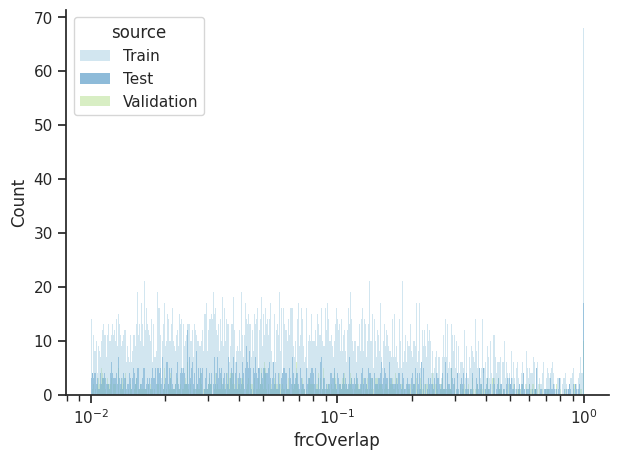

In [3]:

df_train['source'] = 'Train'
df_test['source'] = 'Test'
df_val['source'] = 'Validation'
df_combined = pd.concat([df_train, df_test, df_val], ignore_index=True)
sns.set_theme(style="ticks")

f, ax = plt.subplots(figsize=(7, 5))
sns.despine(f)

sns.histplot(
    df_combined,
    x="frcOverlap",
    hue="source",
    bins=1000,
    # multiple="stack",
    palette="Paired",
    edgecolor=None,
    linewidth=0,
    log_scale=True,
)

print(f'Train:\n\taverage {df_train['frcOverlap'].mean()}\n\tvariance {df_train['frcOverlap'].var()}')
print(f'Test:\n\taverage {df_test['frcOverlap'].mean()}\n\tvariance {df_test['frcOverlap'].var()}')
print(f'Validation:\n\taverage {df_val['frcOverlap'].mean()}\n\tvariance {df_val['frcOverlap'].var()}')

In [4]:
# os.makedirs('data/train', exist_ok=True)
# os.makedirs('data/test', exist_ok=True)
# os.makedirs('data/validation', exist_ok=True)

# def copy_from_to(df, split):
#     total = len(df['name'])
#     for i, name in enumerate(df['name']):
#         print(f'\r{i}/{total} done', end="")
#         if os.path.exists(f'data/Raw/S2_14_2019/{name}.tif'):
#             source = f'data/Raw/S2_14_2019/{name}.tif'
#             dest =  f'data/{split}/{name}.tif'
#             shutil.copy(source, dest)
#     print()

# copy_from_to(df_train, 'train')
# copy_from_to(df_test, 'test')
# copy_from_to(df_val, 'validation')

In [5]:
def img_to_vec(path):
    with rasterio.open(path) as src:
        data = src.read()
        bands, _, _ = data.shape
        normalized_data = np.empty_like(data, dtype=np.float32)
        scaler = MinMaxScaler()
        for i in range(bands):
            band = data[i].reshape(-1, 1)
            norm_band = scaler.fit_transform(band).reshape(data.shape[1:])
            normalized_data[i] = norm_band

        pixels = normalized_data.reshape(bands, -1).T
        
        if '_mine' in src.descriptions:
            y = pixels[:, -1]
            X = np.delete(pixels, -1, axis=1)
        else:
            y = np.zeros(pixels.shape[0])
            X = pixels
        
        return X, y


In [6]:

lambdas = lambdas = np.logspace(-4, 0, 50).tolist()
remaining_loss = []
coefficients = []
IMG_NR = 10
for l in lambdas:
    X = []
    y = []
    for i, img in enumerate(os.listdir('data/train')):
        t_X, t_y = img_to_vec('data/train/'+img)
        X.append(t_X)
        y.append(t_y)
        if i >= IMG_NR:
            break
    
    X = np.concatenate(X)
    y = np.concatenate(y)
    lasso = Lasso(alpha=l, max_iter=2000)
    lasso.fit(X, y)
    coeffs = lasso.coef_
    y_pred = lasso.predict(X)
    mse = mean_squared_error(y, y_pred)
    # l1_penalty = l * np.sum(np.abs(coeffs))
    loss = mse # + l1_penalty

    remaining_loss.append(loss)
    coefficients.append(coeffs)
    


<Figure size 1000x600 with 0 Axes>

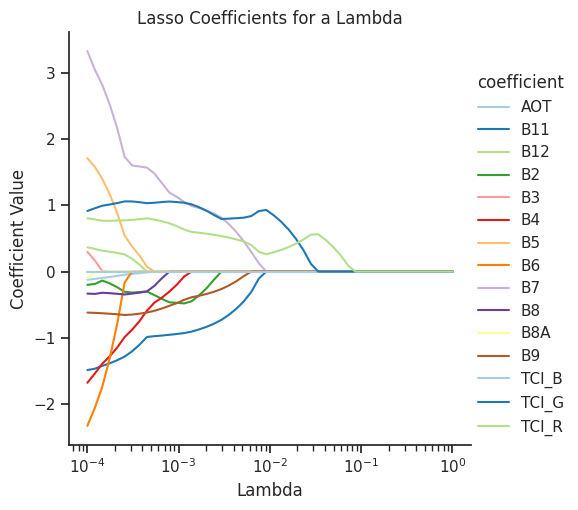

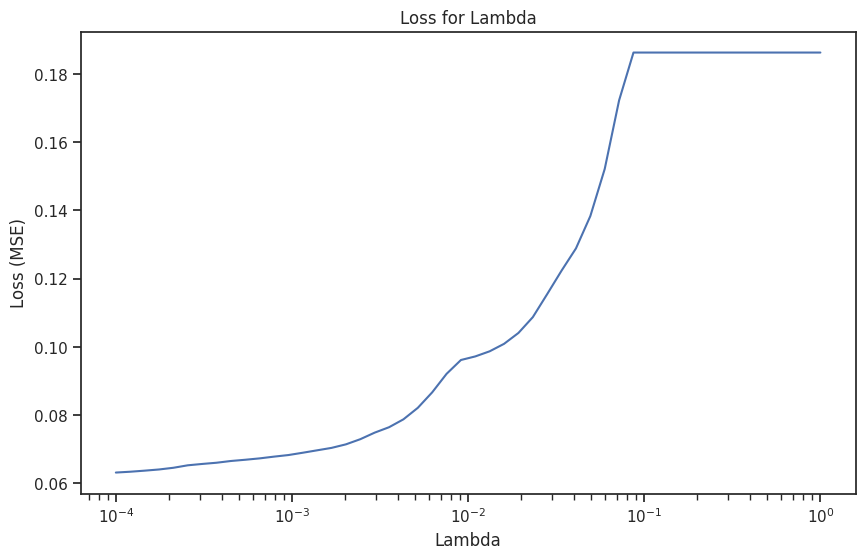

In [12]:
combined = zip(lambdas, coefficients)
table = []

for (l, coeffs) in combined:
    result = {}
    result['lambda'] = l
    for i, coeff in enumerate(coeffs):
        result[CHANNELS[i]] = coeff
    table.append(result)

df_result = pd.DataFrame(table)
df_long = df_result.melt(id_vars='lambda', var_name='coefficient', value_name='magnitude')

# Plot the change in coefficients
plt.figure(figsize=(10, 6))
sns.relplot(data=df_long, kind='line', x='lambda', y='magnitude', hue='coefficient', palette="Paired")
plt.xscale("log") 
plt.title("Lasso Coefficients for a Lambda")
plt.xlabel("Lambda")
plt.ylabel("Coefficient Value")
plt.show()

# Plot the change in loss
loss_lambdas = pd.DataFrame(map(lambda x: {"lambda": x[0], "loss": x[1]}, zip(lambdas, remaining_loss)))
plt.figure(figsize=(10, 6))
sns.lineplot(data=loss_lambdas, x='lambda', y='loss')
plt.xscale("log")
plt.title("Loss for Lambda")
plt.xlabel("Lambda")
plt.ylabel("Loss (MSE)")
plt.show()
